In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.odr import ODR, Model, RealData

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)

from main_code.utils.constants import *
from main_code.utils.CosmoFunc import *
from main_code.utils.functions import bin_data, bin_data_error_weighting

# Calculate DM for Cullan's data

In [2]:
from main_code.step_9_distance_modulus import calculate_distance_modulus

# Load Cullan's data
df = pd.read_csv("../../data/external/h22/cullan_logdist.csv")

df["DM100"], df["eDM100"] = calculate_distance_modulus(
    z_dist_est=df["zcmb_group"].to_numpy(),
    z_helio=df["zhelio"].to_numpy(),
    logdist=df["logdist_corr"].to_numpy(),
    logdist_err=df["logdist_corr_err"].to_numpy(),
    H0=100.
)

df["DM75"], df["eDM75"] = calculate_distance_modulus(
    z_dist_est=df["zcmb_group"].to_numpy(),
    z_helio=df["zhelio"].to_numpy(),
    logdist=df["logdist_corr"].to_numpy(),
    logdist_err=df["logdist_corr_err"].to_numpy(),
    H0=75.
)

df.to_csv("./cullan_dm.csv", index=False)

# Create lookup table to convert PGC to survey ID

In [ ]:
df = pd.read_csv("../../data/external/cf4/raw/cf4_sdss_subsample.txt")

df = df[["pgc", "objid"]]

df.to_csv("../../data/external/cf4/pgc_to_id/sdss.csv", index=False)

In [16]:
df = pd.read_csv("../../data/external/cf4/raw/cf4_6dfgs_subsample.txt")

df = df[["pgc", "Name"]]

df.to_csv("../../data/external/cf4/pgc_to_id/6dfgs.csv", index=False)

# Compare 6dFGS subsample

Rejected comparison in individual: 3
Rejected comparison in combined: 3


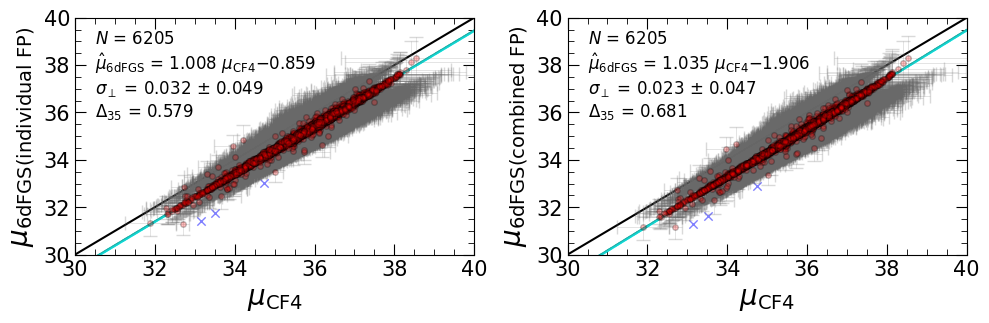

In [ ]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]


# Load CF4 individual distance data
df_cf4 = pd.read_csv("../../data/external/cf4/raw/CF4_all_individual.txt")[["pgc", "DM", "eDM"]]
df_cf4.rename({"DM": "DM_cf4", "eDM": "eDM_cf4"}, axis=1, inplace=True)

# Load my 6dFGS DM measurements
df_mine = pd.read_csv("../../data/foundation/distance_modulus/6dfgs.csv")
df_mine.rename({"_6dFGS": "Name"}, axis=1, inplace=True)

# Get PGC id for my data
df_lookup = pd.read_csv("../../data/external/cf4/pgc_to_id/6dfgs.csv")
df_mine = df_mine.merge(df_lookup, on="Name", how="left")

# Cross-match between my data vs CF4
df_full = df_mine.merge(df_cf4, on="pgc", how="left")


methods = ["individual", "combined"]
sigma_clip = 3.5

figure_size = 5
fig, ax = plt.subplots(ncols=2, figsize=(figure_size * 2, figure_size / 1.5))
for i, ax in enumerate(fig.axes):
    method = methods[i]

    df = df_full.copy()
    df["chisq"] = np.absolute(df[f"DM_{method}_fp"] - df["DM_cf4"]) / np.sqrt(df[f"eDM_{method}_fp"]**2 + df["eDM_cf4"]**2)
    df_rejects = df[df["chisq"] > sigma_clip]
    print(f"Rejected comparison in {method}: {len(df_rejects)}")
    df = df[df["chisq"] <= sigma_clip]

    ndata = len(df)

    x = df[f"DM_cf4"].to_numpy()
    xerr = df[f"eDM_cf4"].to_numpy()
    y = df[f"DM_{method}_fp"].to_numpy()
    yerr = df[f"eDM_{method}_fp"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    left_ = 30
    right_ = 40

    x_trial = np.linspace(left_, right_, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.25, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects[f"DM_cf4"], df_rejects[f"DM_{method}_fp"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([left_, right_], [left_, right_], c='k')

    ax.set_xlim(left_, right_)
    ax.set_ylim(left_, right_)
    ax.set_ylabel(r"$\mu_\mathrm{survey1}$".replace("survey1", f"6dFGS ({method}\ FP)"), fontsize=20)
    ax.set_xlabel(r"$\mu_\mathrm{survey2}$".replace("survey2", "CF4"), fontsize=20)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)
    delta_35 = np.round(35 - m_value * 35 - b_value, 3)

    N_text = rf"$N$ = {N_value}"
    y_text = r"$\hat{\mu}_\mathrm{6dFGS}$" + f" = ${m_value}$ " + r"$\mu_\mathrm{CF4}$" + rf"${b_value}$"
    delta_text = r"$\Delta_{35}$" + rf" = ${delta_35}$"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + y_text + "\n" + sigma_text + "\n" + delta_text
    ax.text(0.05, 0.95, text_, transform=ax.transAxes, fontsize=12, 
         verticalalignment='top', horizontalalignment='left')
    
fig.tight_layout()
fig.savefig("./6dfgs_cf4_comparison.pdf", bbox_inches='tight', dpi=300)

# Compare SDSS subsample

Rejected comparison in individual: 2
Rejected comparison in combined: 1


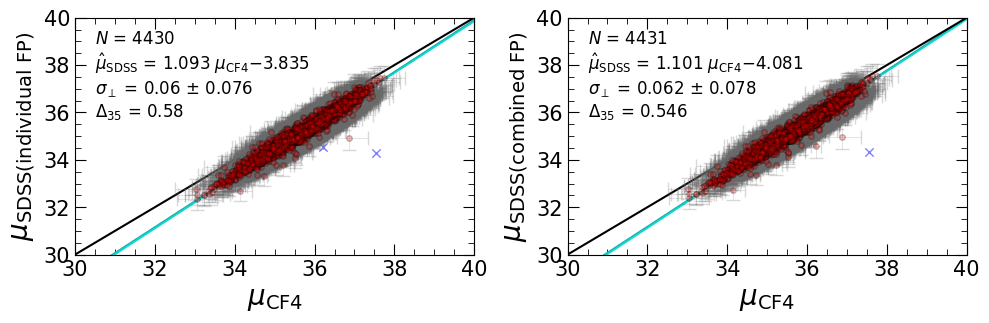

In [37]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]


# Load CF4 individual distance data
df_cf4 = pd.read_csv("../../data/external/cf4/raw/CF4_all_individual.txt")[["pgc", "DM", "eDM"]]
df_cf4.rename({"DM": "DM_cf4", "eDM": "eDM_cf4"}, axis=1, inplace=True)

# Load my 6dFGS DM measurements
df_mine = pd.read_csv("../../data/foundation/distance_modulus/sdss.csv")

# Get PGC id for my data
df_lookup = pd.read_csv("../../data/external/cf4/pgc_to_id/sdss.csv")
df_lookup["objid"] = df_lookup["objid"].apply(lambda x: "SDSS" + str(x))
df_mine = df_mine.merge(df_lookup, on="objid", how="left")

# Cross-match between my data vs CF4
df_full = df_mine.merge(df_cf4, on="pgc", how="left")


methods = ["individual", "combined"]
sigma_clip = 3.5

figure_size = 5
fig, ax = plt.subplots(ncols=2, figsize=(figure_size * 2, figure_size / 1.5))
for i, ax in enumerate(fig.axes):
    method = methods[i]

    df = df_full.copy()
    df["chisq"] = np.absolute(df[f"DM_{method}_fp"] - df["DM_cf4"]) / np.sqrt(df[f"eDM_{method}_fp"]**2 + df["eDM_cf4"]**2)
    df_rejects = df[df["chisq"] > sigma_clip]
    print(f"Rejected comparison in {method}: {len(df_rejects)}")
    df = df[df["chisq"] <= sigma_clip]

    ndata = len(df)
    y = df[f"DM_{method}_fp"].to_numpy()
    yerr = df[f"eDM_{method}_fp"].to_numpy()
    x = df[f"DM_cf4"].to_numpy()
    xerr = df[f"eDM_cf4"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    left_ = 30
    right_ = 40

    x_trial = np.linspace(left_, right_, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.25, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects["DM_cf4"], df_rejects[f"DM_{method}_fp"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([left_, right_], [left_, right_], c='k')

    ax.set_xlim(left_, right_)
    ax.set_ylim(left_, right_)
    ax.set_ylabel(r"$\mu_\mathrm{survey1}$".replace("survey1", f"SDSS ({method}\ FP)"), fontsize=20)
    ax.set_xlabel(r"$\mu_\mathrm{survey2}$".replace("survey2", "CF4"), fontsize=20)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)
    delta_35 = np.round(35 - m_value * 35 - b_value, 3)

    N_text = rf"$N$ = {N_value}"
    y_text = r"$\hat{\mu}_\mathrm{SDSS}$" + f" = ${m_value}$ " + r"$\mu_\mathrm{CF4}$" + rf"${b_value}$"
    delta_text = r"$\Delta_{35}$" + rf" = ${delta_35}$"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + y_text + "\n" + sigma_text + "\n" + delta_text
    ax.text(0.05, 0.95, text_, transform=ax.transAxes, fontsize=12, 
         verticalalignment='top', horizontalalignment='left')
    
fig.tight_layout()
fig.savefig("./sdss_cf4_comparison.pdf", bbox_inches='tight', dpi=300)

# Trend with redshift

In [83]:
# # Load CF4 individual distance data
# df_cf4 = pd.read_csv("../../data/external/cf4/raw/CF4_all_individual.txt")[["pgc", "DM", "eDM"]]
# df_cf4.rename({"DM": "DM_cf4", "eDM": "eDM_cf4"}, axis=1, inplace=True)

# # Load my 6dFGS DM measurements
# df_mine = pd.read_csv("../../data/foundation/distance_modulus/sdss.csv")

# # Get PGC id for my data
# df_lookup = pd.read_csv("../../data/external/cf4/pgc_to_id/sdss.csv")
# df_lookup["objid"] = df_lookup["objid"].apply(lambda x: "SDSS" + str(x))
# df_mine = df_mine.merge(df_lookup, on="objid", how="left")

# # Cross-match between my data vs CF4
# df_full = df_mine.merge(df_cf4, on="pgc", how="left")

# # Remove outliers
# sigma_clip = 2.5
# method = "individual"
# df_full["chisq"] = np.absolute(df_full[f"DM_{method}_fp"] - df_full["DM_cf4"]) / np.sqrt(df_full[f"eDM_{method}_fp"]**2 + df_full["eDM_cf4"]**2)
# df_full = df_full[np.absolute(df_full["chisq"]) <= sigma_clip]

# # Calculate difference in mu
# df_full["delta_mu"] = df_full[f"DM_{method}_fp"] - df_full["DM_cf4"]


# # Plot the thing
# fig, ax = plt.subplots(figsize=(8, 4))

# x = df_full["z_dist_est"].to_numpy()
# y = df_full["delta_mu"].to_numpy()
# yerr = np.sqrt(df_full[f"eDM_{method}_fp"]**2 + df_full["eDM_cf4"]**2).to_numpy()

# # Bin and do error weighting
# x_bin, y_bin, y_bin_err, y_bin_stderr = bin_data_error_weighting(x, y, yerr, 0.01, 0.055, 20)

# ax.scatter(x, y, s=4, alpha=0.5)
# ax.errorbar(x_bin, y_bin, yerr=y_bin_stderr, fmt="o", mec='k', mfc="red", ecolor="red", alpha=1.0)
# ax.axhline(y=np.median(y), color="k", ls="--")

# ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
# ax.set_ylabel(r"$\mu_\mathrm{SDSS} - \mu_\mathrm{CF4}$", fontsize=18)
# ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
# ax.tick_params(axis='both', which='both', labelsize=12, direction="in")
# ax.tick_params(axis='both', which='major', length=8)
# ax.tick_params(axis='both', which='minor', length=4)

# fig.tight_layout()
# # fig.savefig("./sdss_bias_trend.pdf", bbox_inches='tight', dpi=300)

Rejected comparison in combined: 0
Rejected comparison in combined: 0


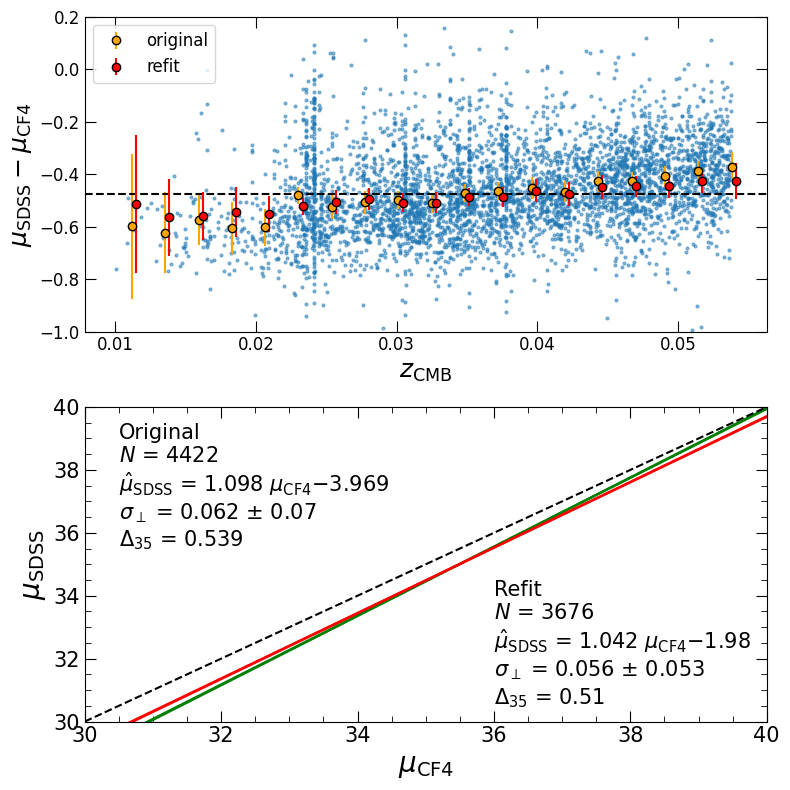

In [38]:
# Load CF4 individual distance data
df_cf4 = pd.read_csv("../../data/external/cf4/raw/CF4_all_individual.txt")[["pgc", "DM", "eDM"]]
df_cf4.rename({"DM": "DM_cf4", "eDM": "eDM_cf4"}, axis=1, inplace=True)

# Load my SDSS DM measurements
df_mine = pd.read_csv("../../data/foundation/distance_modulus/sdss.csv")

# Get PGC id for my data
df_lookup = pd.read_csv("../../data/external/cf4/pgc_to_id/sdss.csv")
df_lookup["objid"] = df_lookup["objid"].apply(lambda x: "SDSS" + str(x))
df_mine = df_mine.merge(df_lookup, on="objid", how="left")

# Cross-match between my data vs CF4
df_full = df_mine.merge(df_cf4, on="pgc", how="left")

# Remove outliers
sigma_clip = 2.5
method = "combined"
df_full["chisq"] = np.absolute(df_full[f"DM_{method}_fp"] - df_full["DM_cf4"]) / np.sqrt(df_full[f"eDM_{method}_fp"]**2 + df_full["eDM_cf4"]**2)
df_full = df_full[np.absolute(df_full["chisq"]) <= sigma_clip]

# Calculate difference in mu
df_full["delta_mu"] = df_full[f"DM_{method}_fp"] - df_full["DM_cf4"]


# Plot the thing
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 4 * 2), height_ratios=[1, 1])

x = df_full["z_dist_est"].to_numpy()
y = df_full["delta_mu"].to_numpy()
yerr = np.sqrt(df_full[f"eDM_{method}_fp"]**2 + df_full["eDM_cf4"]**2).to_numpy()

# Bin and do error weighting
x_bin, y_bin, y_bin_err, y_bin_stderr = bin_data_error_weighting(x, y, yerr, 0.01, 0.055, 20)

ax1.scatter(x, y, s=4, alpha=0.5)
ax1.errorbar(x_bin, y_bin, yerr=y_bin_stderr, fmt="o", mec='k', mfc="orange", ecolor="orange", alpha=1.0, label="original")
ax1.axhline(y=np.median(y), color="k", ls="--")

# Load refitted data
fp_fit = "full"
df_refit = pd.read_csv(f"../experiment_011_refit_cullan_sdss/cullan_sdss_logdist_refit_{fp_fit}_fn.csv")[["objid", "DM_refit", "eDM_refit"]]
df_ = df_full.merge(df_refit, on="objid")
df_["delta_mu_refit"] = df_[f"DM_{method}_fp"] - df_["DM_refit"]
refit_offset = df_["delta_mu"].median() - df_["delta_mu_refit"].median()
df_["delta_mu_refit"] += refit_offset

x_ = df_["z_dist_est"].to_numpy()
y_ = df_["delta_mu_refit"].to_numpy()
yerr_ = np.sqrt(df_[f"eDM_{method}_fp"]**2 + df_["eDM_refit"]**2).to_numpy()
x_bin, y_refit_bin, y_refit_bin_err, y_refit_bin_stderr = bin_data_error_weighting(x_, y_, yerr_, 0.01, 0.055, 20)
# x_bin, y_refit_bin, y_refit_bin_err, y_refit_bin_stderr = bin_data(x_, y_, 0.01, 0.055, 20)
ax1.errorbar(x_bin + 0.0003, y_refit_bin, yerr=y_refit_bin_stderr, fmt="o", mec='k', mfc="red", ecolor="red", alpha=1.0, label="refit")

ax1.legend(fontsize=12)
ax1.set_ylim(-1.0, 0.2)
ax1.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
ax1.set_ylabel(r"$\mu_\mathrm{SDSS} - \mu_\mathrm{CF4}$", fontsize=18)
ax1.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
ax1.tick_params(axis='both', which='both', labelsize=12, direction="in")
ax1.tick_params(axis='both', which='major', length=8)
ax1.tick_params(axis='both', which='minor', length=4)


####################################################################################################################################
# Plot mu vs mu_cf4 (original)
method = "combined"
sigma_clip = 3.5

df = df_full.copy()
df["chisq"] = np.absolute(df[f"DM_{method}_fp"] - df["DM_cf4"]) / np.sqrt(df[f"eDM_{method}_fp"]**2 + df["eDM_cf4"]**2)
df_rejects = df[df["chisq"] > sigma_clip]
print(f"Rejected comparison in {method}: {len(df_rejects)}")
df = df[df["chisq"] <= sigma_clip]

ndata = len(df)
y = df[f"DM_{method}_fp"].to_numpy()
yerr = df[f"eDM_{method}_fp"].to_numpy()
x = df[f"DM_cf4"].to_numpy()
xerr = df[f"eDM_cf4"].to_numpy()
chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

# ODR stuff
linear = Model(f)
mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
myoutput = myodr.run()
# myoutput.pprint()
m_pred, b_pred = myoutput.beta

# Create MC sample
n_trial = 10000
m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

left_ = 30
right_ = 40

x_trial = np.linspace(left_, right_, 1000)
y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
y_pred = m_pred * x_trial + b_pred
y_lower = np.quantile(y_trial, q=0.16, axis=0)
y_upper = np.quantile(y_trial, q=0.84, axis=0)

# Actual data + error bars
# ax2.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='red', mec='k', mfc='red', alpha=0.25, zorder=3)

# Prediction + confidence intervals
ax2.plot(x_trial, y_pred, c='green', ls="--", zorder=2)
ax2.plot(x_trial, y_upper, c='green', ls="-", zorder=2)
ax2.plot(x_trial, y_lower, c='green', ls="-", zorder=2)
ax2.fill_between(x_trial, y1=y_lower, y2=y_upper, color='green', alpha=0.4, zorder=2)

# Rejects
# ax2.scatter(df_rejects["DM_cf4"], df_rejects[f"DM_{method}_fp"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

# 1-to-1 line
ax2.plot([left_, right_], [left_, right_], c='k', ls="--")

ax2.set_xlim(left_, right_)
ax2.set_ylim(left_, right_)
ax2.set_ylabel(r"$\mu_\mathrm{survey1}$".replace("survey1", f"SDSS ({method}\ FP)"), fontsize=20)
ax2.set_xlabel(r"$\mu_\mathrm{survey2}$".replace("survey2", "CF4"), fontsize=20)

ax2.minorticks_on()
ax2.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
ax2.tick_params(axis='both', which='both', labelsize=15, direction="in")
ax2.tick_params(axis='both', which='major', length=8)
ax2.tick_params(axis='both', which='minor', length=4)

# Add text
N_value = len(df)
m_value = np.round(myoutput.beta[0], 3)
m_err = np.round(myoutput.sd_beta[0], 3)
b_value = np.round(myoutput.beta[1], 3)
b_err = np.round(myoutput.sd_beta[1], 3)
sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
sigma_value = np.round(np.median(sigma_ortho), 3)
sigma_err = np.round(np.std(sigma_ortho), 3)
delta_35 = np.round(35 - m_value * 35 - b_value, 3)

suptitle_text = "Original"
N_text = rf"$N$ = {N_value}"
y_text = r"$\hat{\mu}_\mathrm{SDSS}$" + f" = ${m_value}$ " + r"$\mu_\mathrm{CF4}$" + rf"${b_value}$"
delta_text = r"$\Delta_{35}$" + rf" = ${delta_35}$"
sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
text_ = suptitle_text + "\n" + N_text + "\n" + y_text + "\n" + sigma_text + "\n" + delta_text
ax2.text(0.05, 0.95, text_, transform=ax2.transAxes, fontsize=15, 
        verticalalignment='top', horizontalalignment='left')


####################################################################################################################################
# Plot mu vs mu_refit
method = "combined"
sigma_clip = 3.5

df = df_.copy()
df["DM_refit"] -= refit_offset
df["chisq"] = np.absolute(df[f"DM_{method}_fp"] - df["DM_refit"]) / np.sqrt(df[f"eDM_{method}_fp"]**2 + df["eDM_refit"]**2)
df_rejects = df[df["chisq"] > sigma_clip]
print(f"Rejected comparison in {method}: {len(df_rejects)}")
df = df[df["chisq"] <= sigma_clip]

ndata = len(df)
y = df[f"DM_{method}_fp"].to_numpy()
yerr = df[f"eDM_{method}_fp"].to_numpy()
x = df[f"DM_refit"].to_numpy()
xerr = df[f"eDM_refit"].to_numpy()
chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

# ODR stuff
linear = Model(f)
mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
myoutput = myodr.run()
# myoutput.pprint()
m_pred, b_pred = myoutput.beta

# Create MC sample
n_trial = 10000
m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

left_ = 30
right_ = 40

x_trial = np.linspace(left_, right_, 1000)
y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
y_pred = m_pred * x_trial + b_pred
y_lower = np.quantile(y_trial, q=0.16, axis=0)
y_upper = np.quantile(y_trial, q=0.84, axis=0)

# Actual data + error bars
# ax2.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='pink', mec='k', mfc='pink', alpha=0.25, zorder=3)

# Prediction + confidence intervals
ax2.plot(x_trial, y_pred, c='red', ls="--", zorder=2)
ax2.plot(x_trial, y_upper, c='red', ls="-", zorder=2)
ax2.plot(x_trial, y_lower, c='red', ls="-", zorder=2)
ax2.fill_between(x_trial, y1=y_lower, y2=y_upper, color='red', alpha=0.4, zorder=2)

# Rejects
# ax2.scatter(df_rejects["DM_refit"], df_rejects[f"DM_{method}_fp"], marker="x", c="orange", lw=1., alpha=0.5, zorder=2)

ax2.set_xlim(left_, right_)
ax2.set_ylim(left_, right_)
ax2.set_ylabel(r"$\mu_\mathrm{survey1}$".replace("survey1", f"SDSS"), fontsize=20)
ax2.set_xlabel(r"$\mu_\mathrm{survey2}$".replace("survey2", "CF4"), fontsize=20)

ax2.minorticks_on()
ax2.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
ax2.tick_params(axis='both', which='both', labelsize=15, direction="in")
ax2.tick_params(axis='both', which='major', length=8)
ax2.tick_params(axis='both', which='minor', length=4)

# Add text
N_value = len(df)
m_value = np.round(myoutput.beta[0], 3)
m_err = np.round(myoutput.sd_beta[0], 3)
b_value = np.round(myoutput.beta[1], 3)
b_err = np.round(myoutput.sd_beta[1], 3)
sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
sigma_value = np.round(np.median(sigma_ortho), 3)
sigma_err = np.round(np.std(sigma_ortho), 3)
delta_35 = np.round(35 - m_value * 35 - b_value, 3)

suptitle_text = "Refit"
N_text = rf"$N$ = {N_value}"
y_text = r"$\hat{\mu}_\mathrm{SDSS}$" + f" = ${m_value}$ " + r"$\mu_\mathrm{CF4}$" + rf"${b_value}$"
delta_text = r"$\Delta_{35}$" + rf" = ${delta_35}$"
sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
text_ = suptitle_text + "\n" + N_text + "\n" + y_text + "\n" + sigma_text + "\n" + delta_text
ax2.text(0.6, 0.45, text_, transform=ax2.transAxes, fontsize=15, 
        verticalalignment='top', horizontalalignment='left')


fig.tight_layout()
# fig.savefig("./sdss_bias_trend.pdf", bbox_inches='tight', dpi=300)

# 6dFGS trend with redshift

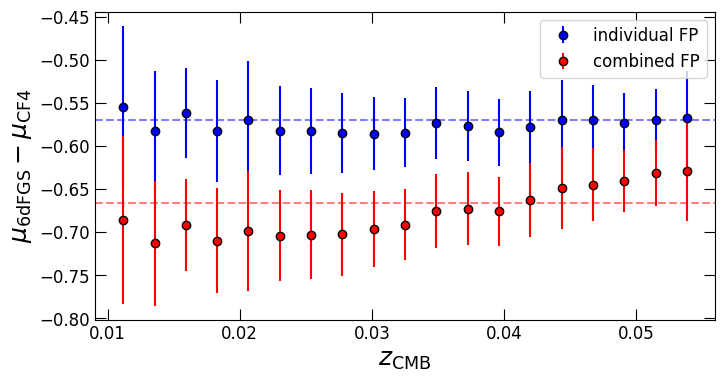

In [34]:
# Load CF4 individual distance data
df_cf4 = pd.read_csv("../../data/external/cf4/raw/CF4_all_individual.txt")[["pgc", "DM", "eDM"]]
df_cf4.rename({"DM": "DM_cf4", "eDM": "eDM_cf4"}, axis=1, inplace=True)

# Load my 6dFGS DM measurements
df_mine = pd.read_csv("../../data/foundation/distance_modulus/6dfgs.csv")
df_mine.rename({"_6dFGS": "Name"}, axis=1, inplace=True)

# Get PGC id for my data
df_lookup = pd.read_csv("../../data/external/cf4/pgc_to_id/6dfgs.csv")
df_mine = df_mine.merge(df_lookup, on="Name", how="left")

# Cross-match between my data vs CF4
df_full = df_mine.merge(df_cf4, on="pgc", how="left")

# Remove outliers
sigma_clip = 2.5

colors = ["blue", "red"]

# Plot the thing
fig, (ax1) = plt.subplots(nrows=1, figsize=(8, 4))
for i, method in enumerate(["individual", "combined"]):
    df_full["chisq"] = np.absolute(df_full[f"DM_{method}_fp"] - df_full["DM_cf4"]) / np.sqrt(df_full[f"eDM_{method}_fp"]**2 + df_full["eDM_cf4"]**2)
    df_full = df_full[np.absolute(df_full["chisq"]) <= sigma_clip]

    # Calculate difference in mu
    df_full[f"delta_mu"] = df_full[f"DM_{method}_fp"] - df_full["DM_cf4"]

    x = df_full["z_dist_est"].to_numpy()
    y = df_full["delta_mu"].to_numpy()
    yerr = np.sqrt(df_full[f"eDM_{method}_fp"]**2 + df_full["eDM_cf4"]**2).to_numpy()

    # Bin and do error weighting
    x_bin, y_bin, y_bin_err, y_bin_stderr = bin_data_error_weighting(x, y, yerr, 0.01, 0.055, 20)

    # ax1.scatter(x, y, s=4, alpha=0.5)
    ax1.errorbar(x_bin, y_bin, yerr=y_bin_stderr, fmt="o", mec='k', mfc=colors[i], ecolor=colors[i], alpha=1.0, label=f"{method} FP")
    ax1.axhline(y=np.median(y), color=colors[i], ls="--", alpha=0.5)
    
ax1.legend(fontsize=12)
# ax1.set_ylim(-1.0, 0.2)
ax1.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
ax1.set_ylabel(r"$\mu_\mathrm{6dFGS} - \mu_\mathrm{CF4}$", fontsize=18)
ax1.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
ax1.tick_params(axis='both', which='both', labelsize=12, direction="in")
ax1.tick_params(axis='both', which='major', length=8)
ax1.tick_params(axis='both', which='minor', length=4)

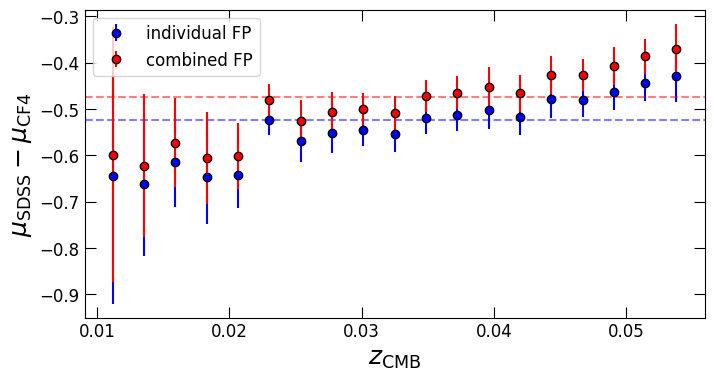

In [ ]:
# Load CF4 individual distance data
df_cf4 = pd.read_csv("../../data/external/cf4/raw/CF4_all_individual.txt")[["pgc", "DM", "eDM"]]
df_cf4.rename({"DM": "DM_cf4", "eDM": "eDM_cf4"}, axis=1, inplace=True)

# Load my 6dFGS DM measurements
df_mine = pd.read_csv("../../data/foundation/distance_modulus/sdss.csv")
# df_mine.rename({"_6dFGS": "Name"}, axis=1, inplace=True)

# Get PGC id for my data
df_lookup = pd.read_csv("../../data/external/cf4/pgc_to_id/sdss.csv")
df_lookup["objid"] = df_lookup["objid"].apply(lambda x: "SDSS" + str(x))
df_mine = df_mine.merge(df_lookup, on="objid", how="left")

# Cross-match between my data vs CF4
df_full = df_mine.merge(df_cf4, on="pgc", how="left")

# Remove outliers
sigma_clip = 2.5

colors = ["blue", "red"]

# Plot the thing
fig, (ax1) = plt.subplots(nrows=1, figsize=(8, 4))
for i, method in enumerate(["individual", "combined"]):
    df_full["chisq"] = np.absolute(df_full[f"DM_{method}_fp"] - df_full["DM_cf4"]) / np.sqrt(df_full[f"eDM_{method}_fp"]**2 + df_full["eDM_cf4"]**2)
    df_full = df_full[np.absolute(df_full["chisq"]) <= sigma_clip]

    # Calculate difference in mu
    df_full[f"delta_mu"] = df_full[f"DM_{method}_fp"] - df_full["DM_cf4"]

    x = df_full["z_dist_est"].to_numpy()
    y = df_full["delta_mu"].to_numpy()
    yerr = np.sqrt(df_full[f"eDM_{method}_fp"]**2 + df_full["eDM_cf4"]**2).to_numpy()

    # Bin and do error weighting
    x_bin, y_bin, y_bin_err, y_bin_stderr = bin_data_error_weighting(x, y, yerr, 0.01, 0.055, 20)

    # ax1.scatter(x, y, s=4, alpha=0.5)
    ax1.errorbar(x_bin, y_bin, yerr=y_bin_stderr, fmt="o", mec='k', mfc=colors[i], ecolor=colors[i], alpha=1.0, label=f"{method} FP")
    ax1.axhline(y=np.median(y), color=colors[i], ls="--", alpha=0.5)
    
ax1.legend(fontsize=12)
# ax1.set_ylim(-1.0, 0.2)
ax1.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
ax1.set_ylabel(r"$\mu_\mathrm{SDSS} - \mu_\mathrm{CF4}$", fontsize=18)
ax1.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
ax1.tick_params(axis='both', which='both', labelsize=12, direction="in")
ax1.tick_params(axis='both', which='major', length=8)
ax1.tick_params(axis='both', which='minor', length=4)